# Data Model for predicting the sales of a given item for a given week - Using linear regression

## Data
1. train_data.csv - A dataset with the daily sales of each item
2. validation_data.csv - A dataset of the weekly sales of a selected number of items
3. test_data.csv - A dataset to be completed by perdicted values of sales

### Step 1: Organizing the data
Create a dataset with the weekly sales (named *weekly_data.csv*) of the items from the train_data.csv file

### Step 2: Creating a model using Linear Regression to forecast future values
Create a data model using libraries in scikit learn to forecast future sales values

### Step 3: Validating the data model using existing data
Use the data given in *validation_data.csv* to evaluate the accuracy of the data model. Here the **Total Mean Absolute Percentage Error(MAPE)** is used to evaluate the accuracy of the model

### Step 4: Predicting the values
Predict the sales for the items given in the *test_data.csv* file to the nearest integer value

In [68]:
# Required dependencies - Data filtering
from csv import DictReader, DictWriter
from datetime import datetime as dt
from datetime import timedelta as td

In [69]:
# Required libraries for model training
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt 

### Step 01 - Data Filtering and Preparation
This following cell includes data filtering functions. It filers out the data from the train_data.csv file and
writes the filtered data to the weekly_data.csv file in the format that is required by the 
model training libraries

In [70]:

# A function to filter out the items in each week

def filterItems(train_dataset_file:str, start_date:str, end_date:str) -> dict:
    with open(train_dataset_file) as f:
        data = DictReader(f)

        start_date = dt.strptime(start_date, "%m/%d/%Y")
        end_date = dt.strptime(end_date, "%m/%d/%Y")
        week = td(days=7)
        days_td = (end_date-start_date)
        num_weeks = int((((days_td.total_seconds()//3600)//24)//7))

        weeks = {f'w{j+1}':{'start':start_date+j*week,'items':{}} for j in range(num_weeks)}

        for row in data:
            date = dt.strptime(row['DateID'], '%m/%d/%Y')
            for key, value in weeks.items():

                start,items = value['start'], value['items']
    
                if start<=date<=start+week*4:
                    # If the item was added earlier
                    if row['ItemCode'] in items.keys():
                        items[row['ItemCode']]['WeeklySales']+=int(row['DailySales'])
                    # If the item was not added
                    else:
                        items[row['ItemCode']] = {
                            'CategoryCode':row['CategoryCode'],
                            'ItemCode':row['ItemCode'],
                            'WeeklySales':0
                        }
    return weeks


# A function to write data into a new csv file
def writeWeeklyData(dataset:dict, filename:str) -> None:
    contents = []
    for key, value in dataset.items():
        allitems = value['items']
        
        for _, items in allitems.items():

            content = {
                'CategoryCode': int(items['CategoryCode'].split("_")[-1]),
                'ItemCode': int(items['ItemCode']),
                'Week':int(key[1::]),
                'WeeklySales':int(items['WeeklySales'])
            }
            contents.append(content)
    
    with open(filename, 'w', newline='') as f:
        fieldnames = ['CategoryCode', 'ItemCode', 'Week', 'WeeklySales']
        writer = DictWriter(f, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()
        writer.writerows(contents)

# Get the data
weeks = filterItems('./train_data.csv', '10/01/2021', '02/13/2022')
writeWeeklyData(weeks, './weekly_data.csv')


### Step 02 - Model creation and training
The following cells creates and trains a Linear Regression model on the given training data

In [71]:
# Read data from the weekly_data file
data = pd.read_csv('./weekly_data.csv')
data

,CategoryCode,ItemCode,Week,WeeklySales
0,2,1090249,1,45
1,2,1098493,1,33
2,4,1060909,1,226
3,2,174436,1,280
4,1,36898,1,254
...,...,...,...,...
3662,4,1074823,19,9
3663,1,1044610,19,5
3664,2,86974,19,0
3665,4,872260,19,0


In [72]:
# A model using linear regression
model_LR = LinearRegression()
model_LR.fit(data[['CategoryCode', 'ItemCode', 'Week']].values, data.WeeklySales)
model_RD = Ridge(alpha=0.5)
model_RD.fit(data[['CategoryCode', 'ItemCode', 'Week']].values, data.WeeklySales)
print("Linear Regression Model: ", "Coefficients: ", model_LR.coef_, "Intercept:", model_LR.intercept_)
print("Ridge Model: ", "Coefficients: ", model_RD.coef_, "Intercept:", model_RD.intercept_)

Linear Regression Model:  Coefficients:  [ 5.92939249e+01 -1.14508019e-04 -2.40784693e+00] Intercept: 128.49642046817291
Ridge Model:  Coefficients:  [ 5.92832180e+01 -1.14506256e-04 -2.40783935e+00] Intercept: 128.51580192271587


### Step 03 - Validating the data model
Validate the data model created in the above cells

In [73]:
# Function to get the validation data
def validateModel(validation_filename:str, offset_weeks:int, Datamodel) -> dict:
    with open(validation_filename, newline='') as f:
        data = DictReader(f)
        predicted = []
        sales = []

        for row in data:
            # Format the data as required
            categorycode = int(row['CategoryCode'].split('_')[-1])
            itemcode = int(row['ItemCode'])
            week = int(row['Week'][1::])+offset_weeks    

            # Run the model to predict the weeklysales
            predicted_sales = Datamodel.predict([[categorycode, itemcode, week]])[0]

            # Check accuracy of the model
            sale = int(row['WeeklySales'])
            predicted.append((itemcode, predicted_sales))
            sales.append((itemcode, sale))
        
    return {'predicted':predicted, 'sales':sales}

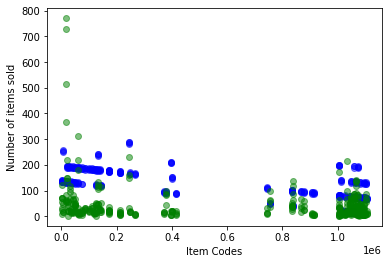

In [74]:
# Plot the predicted sales and actual sales values - Linear Regression Model
sales_dict = validateModel('./validation_data.csv', offset_weeks=19, Datamodel=model_LR)
itemcodes = [item[0] for item in sales_dict['predicted']]
predicted_values = [item[1] for item in sales_dict['predicted']]
actual_values = [item[1] for item in sales_dict['sales']]

# Setup scatter plot
plt.scatter(itemcodes, predicted_values, c="blue", alpha=0.5)
plt.scatter(itemcodes, actual_values, c="green", alpha=0.5)
plt.xlabel("Item Codes")
plt.ylabel("Number of items sold")

# plot the graph
plt.show()

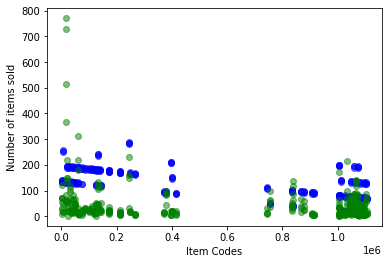

In [75]:
# Plot the predicted sales and actual sales values - Ridge Model
sales_dict = validateModel('./validation_data.csv', offset_weeks=19, Datamodel=model_RD)
itemcodes = [item[0] for item in sales_dict['predicted']]
predicted_values = [item[1] for item in sales_dict['predicted']]
actual_values = [item[1] for item in sales_dict['sales']]

# Setup scatter plot
plt.scatter(itemcodes, predicted_values, c="blue", alpha=0.5)
plt.scatter(itemcodes, actual_values, c="green", alpha=0.5)
plt.xlabel("Item Codes")
plt.ylabel("Number of items sold")

# plot the graph
plt.show()

### Step 04 - Predict the weekly sales
Predict the weekly sales for the items given in the *test_data.csv* file

In [76]:
def predictValues(input_filename:str, output_filename:str, offset_weeks:int, Datamodel) -> dict:
    # Read the test data and calculate predict the weekly sales
    with open (input_filename, newline='') as inputfile:
        data = DictReader(inputfile)
        contents = []

        for row in data:
            # Format the data as required
            categorycode = int(row['CategoryCode'].split('_')[-1])
            itemcode = int(row['ItemCode'])
            week = int(row['Week'][1::])+offset_weeks
            
            # Run the model to predict the weeklysales
            predictedsales = Datamodel.predict([[categorycode, itemcode, week]])

            # Create dict object to be written to the csv file 
            content = {
                'CategoryCode': row['CategoryCode'],
                'ItemCode': row['ItemCode'],
                'Week': row['Week'],
                'PredictedSales': round(predictedsales[0])
            }
        
            contents.append(content)
    
    # Write the predicted sales to a new file
    with open(output_filename, 'w', newline='') as outputfile:
        fieldnames = ['CategoryCode', 'ItemCode', 'Week', 'PredictedSales']
        writer = DictWriter(outputfile, fieldnames=fieldnames)

        # write the header
        writer.writeheader()
        writer.writerows(contents)
    
    contents_dict = {item['ItemCode']:item for item in contents}
    return contents_dict
    
# Predict the values
contents_dict = predictValues('./test_data.csv', './predicted_test_data.csv', offset_weeks=19, Datamodel=model_LR)

## Results - 
#### Total MAPE Score of the Model = 1.68904

This means the results are accurate with a maximum tolerance of 2 items, which means the predictions are quite informative if the trends in the market do not change drastically from that of the last 5 months.
